# Topic: Fama-French Equity Factors over Business Cycles

* Feburary 20 Python Markdown Submission: Data read-in, visualization, and EDA
* Group members: Kenneth Chen, Yoshiyasu Kawamura, Byungsoo Kim, Patrick Wang
* For the data and detailed python code please visit our GitHub repo: https://github.com/patrickwjwang/equity-cycle


## Background settings

In [45]:
# Import packages
import os
import sys
import warnings
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.interpolate import make_interp_spline

# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
src_dir = os.path.join(base_dir, 'src')
sys.path.append(src_dir)

# Ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)  

## 1. Risk factors data

In [36]:
# Some EDA using FF6 risk factors data

## 2. Stock data

In [37]:
# Some EDA using stock data

## 3. Construct optimal potfolios using stock data

We wrote a python class called `OptimalPortfolios`, stored in the `src` directory. The doc string for this class is printed out below.

In [44]:
from optimal_portfolios import OptimalPortfolios
help(OptimalPortfolios)

Help on class OptimalPortfolios in module optimal_portfolios:

class OptimalPortfolios(builtins.object)
 |  OptimalPortfolios(stock_df, num_pfo)
 |  
 |  OptimalPortfolios calculates optimal portfolio weights using the Efficient Frontier method 
 |  and computes portfolio returns over different time frames. 
 |  'Portfolio_1' is the portfolio that achieves 50-quantile stock return with minimized variance
 |  and 'Portfolio_num_pfo' is the 90-quantile stock return with minimized variance
 |  
 |  Attributes:
 |      stock_df (DataFrame): Historical stock prices.
 |      num_pfo (int): Number of portfolios on the efficient frontier.
 |      pfo_returns (list): List of expected returns for each portfolio.
 |      pfo_vars (list): List of variances for each portfolio.
 |  
 |  Example:
 |      stock_df = pd.read_csv('stock_data.csv')
 |      op = OptimalPortfolios(stock_df, num_pfo=5)
 |      op.calculate_efficient_frontier()
 |      print(op.weekly_return)
 |  
 |  Methods defined here:
 

In [50]:
# Example usage of OptimalPortfolios using sample data
stock_df = pd.read_parquet(os.path.join(data_dir, 'sp1500_199603_200111.parquet'))

# Initialize the class and calculate efficient frontier
num_pfo = 10
ef_pfo = OptimalPortfolios(stock_df, num_pfo)
ef_pfo.calculate_efficient_frontier()

# Access returns for the optimized portfolio
daily_return_df = ef_pfo.monthly_return
weekly_return_df = ef_pfo.weekly_return
monthly_return_df = ef_pfo.monthly_return
annual_return_df = ef_pfo.annual_return
annual_return_df.head() 

,portfolio_1,portfolio_2,portfolio_3,portfolio_4,portfolio_5,portfolio_6,portfolio_7,portfolio_8,portfolio_9,portfolio_10
Date,,,,,,,,,,
1997-12-31,0.291056,0.305851,0.323519,0.344971,0.368468,0.392649,0.419314,0.445730,0.473978,0.503408
1998-12-31,-0.015105,-0.003537,0.008597,0.029032,0.057392,0.086527,0.115739,0.145245,0.175971,0.210679
1999-12-31,0.027292,0.049184,0.067371,0.081570,0.093759,0.103862,0.115056,0.126832,0.137487,0.147056
2000-12-31,0.172903,0.204511,0.240880,0.278001,0.310402,0.344436,0.376962,0.407809,0.436122,0.463471
2001-12-31,0.185661,0.200994,0.218750,0.235145,0.256178,0.277707,0.301349,0.326634,0.351059,0.373348


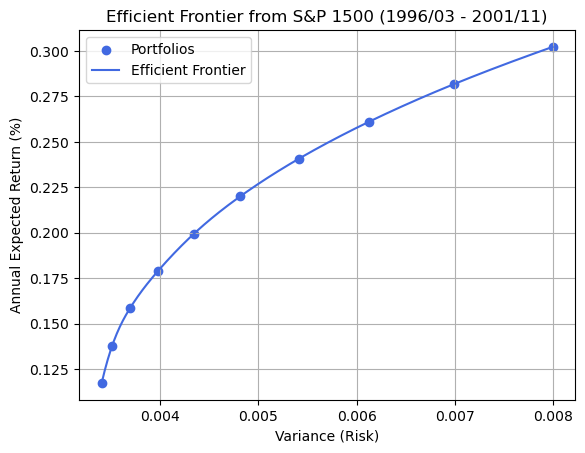

In [55]:
# Convert lists to numpy arrays for easier manipulation
pfo_returns_array = np.array(ef_pfo.pfo_returns)
pfo_vars_array = np.array(ef_pfo.pfo_vars)
sorted_indices = np.argsort(pfo_vars_array)
pfo_vars_sorted = pfo_vars_array[sorted_indices]
pfo_returns_sorted = pfo_returns_array[sorted_indices]

# Creating the spline to smooth efficent frontier
spline = make_interp_spline(pfo_vars_sorted, pfo_returns_sorted, k=3)  # k is the degree of the spline
smooth_vars = np.linspace(pfo_vars_sorted.min(), pfo_vars_sorted.max(), 300)
smooth_returns = spline(smooth_vars)

# Plotting the efficient frontier using the sample data
plt.scatter(ef_pfo.pfo_vars, ef_pfo.pfo_returns, color='royalblue', label='Portfolios')
plt.plot(smooth_vars, smooth_returns, color='royalblue', label='Efficient Frontier')
plt.title('Efficient Frontier from S&P 1500 (1996/03 - 2001/11)')
plt.xlabel('Variance (Risk)')
plt.ylabel('Annual Expected Return (%)')
plt.grid(True)
plt.legend()
plt.show()